# 4. Topic Classification with Supervised Machine Learning


After topic modelling has been done through Latent Dirichlet Allocation (Unsupervised ML), there are 4 distinct topics extracted from the scraped reviews from TripAdvisor for ibis Budget Singapore Hotels. 

**The 4 topics are:** 
1. Location 
2. Room Amenities
3. Environment
4. Service

The reviews are asisgned to its dominant topic and they are now labelled. Using the labelled reviews, supervised machine learning will be applied to create a model for topic classification of future reviews. This will be a multi-class supervised machine learning model. 
This would assist the hotel management to streamline the topic classification process and improve the efficiency when it comes to processing reviews and identifying pain points for service recovery. 

**The flow would be as follows:**
1. Import relevant libraries and dataset
2. Supervised Machine Learning
    - Text Pre-processing - TFIDF Vectorizer 
    - Training Models 
    - Selecting the best model
3. Save and pickle model for deployment 

## 1. Import Relevant Libraries and Dataset

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
random_state = 100

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
df.head()

,Hotel_Name,Date,Title,Review,Rating,Ori_Rating,Cleaned_Review,Dominant_topic,Perc_Contrib,Topic_Keywords,TextBlob_Polarity,Pol_Rating,Topic,Review_Len,Year
0,ibis budget Singapore Pearl,April 2022,When they say budget they mean budget,When they say budget they really mean budget. ...,2,Negative,say budget really mean budget double basically...,0,0.5293,"clean, good, small, walk, staff, location, mrt...",0.001923,Neutral,Location,89,2022
1,ibis budget Singapore Pearl,January 2021,Poor customer service,This hotel does not live up to expectation of ...,3,Neutral,live expectation service standard accord membe...,1,0.3879,"staff, u, service, front, desk, friendly, good...",-0.077597,Negative,Service,54,2021
2,ibis budget Singapore Pearl,February 2020,It's okay,We stayed 4 nights. We got free room promotion...,3,Neutral,stayed night get free promotion double family ...,0,0.6708,"clean, good, small, walk, staff, location, mrt...",0.120055,Neutral,Location,98,2020
3,ibis budget Singapore Pearl,February 2020,Average stay,Located in an area that looks a little more ru...,3,Neutral,locate area look little run rest felt safe alt...,0,0.6372,"clean, good, small, walk, staff, location, mrt...",0.209201,Positive,Location,80,2020
4,ibis budget Singapore Pearl,January 2020,Good budget Hotel,Ibis pearl is good budget hotel in geylang are...,3,Neutral,pearl good budget geylang area compact amenity...,0,0.9890,"clean, good, small, walk, staff, location, mrt...",0.400000,Positive,Location,53,2020


<AxesSubplot:xlabel='Dominant_topic', ylabel='count'>

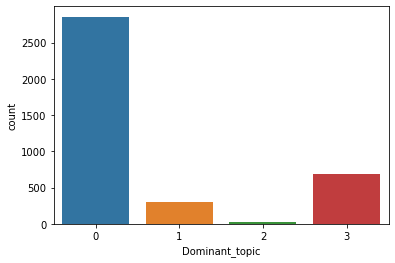

In [4]:
# Visualise the countplot for topics
sns.countplot(x = 'Dominant_topic', data = df)

From the countplot, the dataset is imbalanced and this will need to be addressed during the model training process. 

## 2. Text - Preprocessing - Vectorization

The cleaned and pre-processed reviews from Part 1 will be vectorized through TFIDF Vectorizer. The text will be converted into a term document matrix for input to machine learning models. 

In [5]:
X = df['Cleaned_Review']
y = df['Dominant_topic']

In [6]:
# split data into test and training , set stratify as y as dataset is imbalanced 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state = random_state, stratify = y)

#initiate vectorizer and fit
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df = 0.5)
vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.5, sublinear_tf=True)

In [7]:
#transform to vectors
X_train_v = vectorizer.transform(X_train).toarray()
X_test_v = vectorizer.transform(X_test).toarray()

## 2. Model Training

The classification algorithms used for model training: 
1. Random Forest 
2. AdaBoost 
3. Support Vector Machine
4. Linear SVC

The metric used for selecting the best model will be Accuracy for this multi-class classification.
As this is an imbalanced dataset, the class weights will be adjusted during model training. 

### (a) Random Forest 

In [8]:
# Instantiate the random forest model
clf = RandomForestClassifier(
    n_estimators = 75,
    criterion = 'entropy',
    random_state = random_state,
    class_weight = 'balanced',
    min_samples_split = 20,
    max_samples = 0.5
)

# Fit the model for train data 
clf.fit(X_train_v, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_samples=0.5, min_samples_split=20, n_estimators=75,
                       random_state=100)

In [9]:
y_pred = clf.predict(X_test_v)

In [10]:
# Conduct stratified kfold to prevent overfitting
stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random_state)
scores = cross_val_score(clf, X_train_v, y_train, cv = stratified_kfold)

In [11]:
print('Mean Accuracy Score: %.4f' % np.mean(scores))

Mean Accuracy Score: 0.8478


In [12]:
#Create confusion matrix 
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

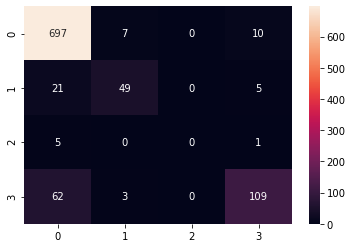

In [13]:
sns.heatmap(cm, annot=True, fmt='d')

In [14]:
# Print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       714
           1       0.83      0.65      0.73        75
           2       0.00      0.00      0.00         6
           3       0.87      0.63      0.73       174

    accuracy                           0.88       969
   macro avg       0.65      0.56      0.60       969
weighted avg       0.88      0.88      0.87       969



C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is pretty high at 0.88 and there are no signs of overfitting. 

### (b) AdaBoost

In [36]:
# Instantiate Adaboost model
clf_ada = AdaBoostClassifier(
    n_estimators = 75,
    random_state = random_state,
    learning_rate = 0.5
)

# fit model to train data 
clf_ada.fit(X_train_v, y_train)

AdaBoostClassifier(learning_rate=0.5, n_estimators=75, random_state=100)

In [37]:
# predict labels using model for test set  
y_pred = clf_ada.predict(X_test_v)

In [38]:
# Conduct stratified kfold to prevent overfitting
stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random_state)
scores = cross_val_score(clf_ada, X_train_v, y_train, cv = stratified_kfold)
print('Mean Accuracy Score: %.4f' % np.mean(scores))

Mean Accuracy Score: 0.7256


<AxesSubplot:>

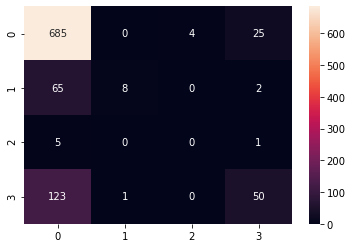

In [39]:
#Create confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [40]:
# Print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       714
           1       0.89      0.11      0.19        75
           2       0.00      0.00      0.00         6
           3       0.64      0.29      0.40       174

    accuracy                           0.77       969
   macro avg       0.58      0.34      0.36       969
weighted avg       0.76      0.77      0.72       969



Adaboost, which uses gradient boosting method, does not seem to give accuracy score as good as Random Forest model. Therefore, this model will not be considered. 

### (c)  SVM

In [8]:
# Instantiate model
svc = SVC(
    class_weight = 'balanced',
    random_state = random_state, 
)

# Fit model to train dataset
svc.fit(X_train_v, y_train)

SVC(class_weight='balanced', random_state=100)

In [9]:
y_pred = svc.predict(X_test_v)

In [10]:
# Conduct stratified kfold to prevent overfitting
stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random_state)
scores = cross_val_score(svc, X_train_v, y_train, cv = stratified_kfold)
print('Mean Accuracy Score: %.4f' % np.mean(scores))

Mean Accuracy Score: 0.9053


<AxesSubplot:>

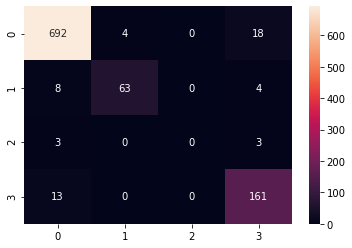

In [11]:
#Create confusion matrix 
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [12]:
# Print classification report 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       714
           1       0.94      0.84      0.89        75
           2       0.00      0.00      0.00         6
           3       0.87      0.93      0.89       174

    accuracy                           0.95       969
   macro avg       0.69      0.68      0.69       969
weighted avg       0.94      0.95      0.94       969



C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score is the highest of all models and there is no overfitting of the model. However, as a TFIDF-Vectorizer produces a sparse matrix and the SVC requires a dense matrix, the model might not be workable when combined with tfidf-vectorizer. Hence , we will try to use linear SVC for our model instead. 

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

### (d) Linear SVC

Linear SVC supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [26]:
# Instantiate model 
lisvc = LinearSVC(
    class_weight = 'balanced'
, random_state = 100)

# Fit model 
lisvc.fit(X_train_v, y_train)

LinearSVC(class_weight='balanced', random_state=100)

In [27]:
# Predict topics using tets dataset
y_pred = lisvc.predict(X_test_v)

In [28]:
# Conduct stratified kfold to prevent overfitting
stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random_state)
scores = cross_val_score(lisvc, X_train_v, y_train, cv = stratified_kfold)
print('Mean Accuracy Score: %.4f' % np.mean(scores))

Mean Accuracy Score: 0.9081


<AxesSubplot:>

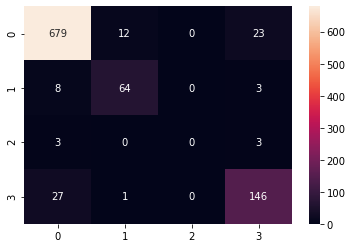

In [29]:
# Visualise confusion matrix through heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       714
           1       0.83      0.85      0.84        75
           2       0.00      0.00      0.00         6
           3       0.83      0.84      0.84       174

    accuracy                           0.92       969
   macro avg       0.65      0.66      0.66       969
weighted avg       0.91      0.92      0.91       969



C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score is still pretty good at 0.92. Hyper-parameter tuning will be done to explore if the accuracy can improve further. 

### Hyper-parameter tuning

In [51]:
# define model and parameters
model = LinearSVC(
    class_weight = 'balanced'
, random_state = random_state)

penalty = ['l1', 'l2']
loss = ['hinge', 'squared_hinge']
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.5, 0.1, 0.01]

# define grid search
grid = dict(penalty= penalty,C=C,loss = loss)
cv = StratifiedKFold(n_splits=3, shuffle = True, random_state= random_state )
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,error_score=0, verbose = 1)
grid_result = grid_search.fit(X_train_v, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    9.7s finished


Best: 0.913257 using {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [52]:
# Generate predictions using model for test dataset
y_pred = grid_search.predict(X_test_v)

<AxesSubplot:>

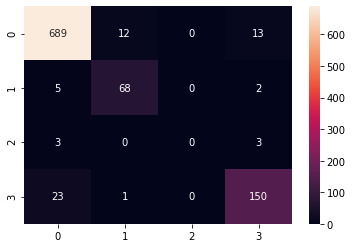

In [53]:
#Generate heatmap of confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       714
           1       0.84      0.91      0.87        75
           2       0.00      0.00      0.00         6
           3       0.89      0.86      0.88       174

    accuracy                           0.94       969
   macro avg       0.67      0.68      0.68       969
weighted avg       0.93      0.94      0.93       969



C:\Users\yeosi\anaconda3\envs\baseclone\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hyper- parameter tuning did improve the accuracy score to 0.94, which is great. F1 score for all clsses did improved too. There are no signs of overfitting as well. Therefore, this is the best model out of all and we will select this model for usage. 

### Best Perfoming Model - Linear SVC

In [55]:
# Instantiate model 
lisvc = LinearSVC( C = 0.1, class_weight = 'balanced', random_state = 100)

# Fit model 
lisvc.fit(X_train_v, y_train)

LinearSVC(C=0.1, class_weight='balanced', random_state=100)

In [56]:
# Predict topics using tets dataset
y_pred = lisvc.predict(X_test_v)

In [57]:
# Conduct stratified kfold to prevent overfitting
stratified_kfold = StratifiedKFold(n_splits=3, shuffle = True,random_state= random_state)
scores = cross_val_score(lisvc, X_train_v, y_train, cv = stratified_kfold)
print('Mean Accuracy Score: %.4f' % np.mean(scores))

Mean Accuracy Score: 0.9133


<AxesSubplot:>

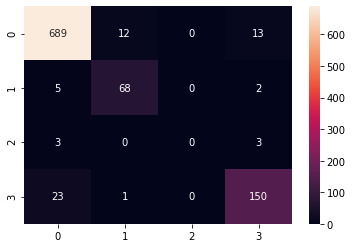

In [58]:
# Visualise confusion matrix through heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       714
           1       0.84      0.91      0.87        75
           2       0.00      0.00      0.00         6
           3       0.89      0.86      0.88       174

    accuracy                           0.94       969
   macro avg       0.67      0.68      0.68       969
weighted avg       0.93      0.94      0.93       969



## 3. Save and pickle model for deployment

In [67]:
# Make pipeline to combine Tfidf vectorizer with model
pipe = make_pipeline(vectorizer, lisvc)

# Save the model as pickle file 
with open('lsvc_pipe_model.pkl', 'wb') as files:
    pickle.dump(pipe, files)

# Try loading model to check if it works     
model = pickle.load(open('lsvc_pipe_model.pkl','rb'))


In [68]:
pred = model.predict(df['Cleaned_Review'])
pred = pd.DataFrame(pred)
pred.value_counts()

0    2846
3     694
1     315
2      19
dtype: int64

In [69]:
# Model works well 
model

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.5, sublinear_tf=True)),
                ('linearsvc',
                 LinearSVC(C=0.1, class_weight='balanced', random_state=100))])

# Conclusion

The model trained using linear SVC provides the highest accuracy of 0.94, therefore, this model is selected for topic classification for hotel reviews. The model can now be used for deployment on Streamlit - pls refer to the Streamlit folder in the same github repo. 